In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import io, measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
import cv2

## File paths

In [25]:
# filepath = r'./images/img0.png'
filepath = r'./images/1.png'
# filepath = r'./images/img1.png'
# filepath = r'./images/1_a.jpg'
# filepath = r'./images/1_b.png' # -> error when the cable appears!
# filepath = r'./images/2_b.png'

## Load file

(480, 640, 3)


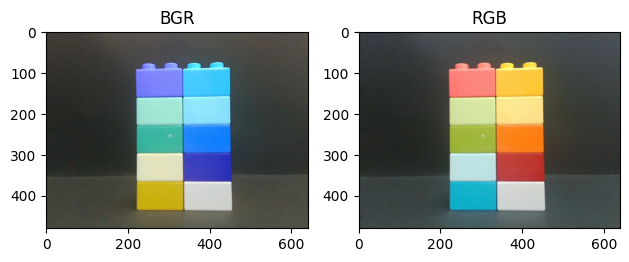

In [26]:
img_BGR = cv2.imread(filepath) # cv2 gives you the BGR color space, but skimage because it load the .jpg wiht RGB colors
img_RGB = io.imread(filepath)
print(img_BGR.shape)

plt.subplot(1, 2, 1)
plt.imshow(img_BGR)
plt.title('BGR')
plt.subplot(1, 2, 2)
plt.imshow(img_RGB)
plt.title('RGB')
plt.tight_layout()
plt.show()

In [27]:
img = img_RGB

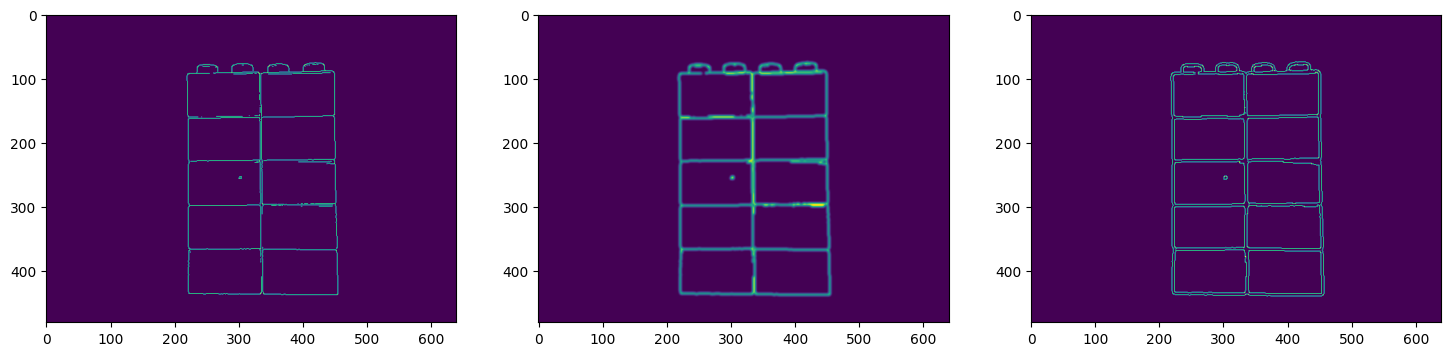

In [28]:
edges_r = cv2.Canny(img, 100, 200)
plt.figure(figsize=(18, 6)) 
plt.subplot(1, 3, 1)
plt.imshow(edges_r)
blurred = cv2.GaussianBlur(edges_r, (9, 9), 0)
plt.subplot(1, 3, 2)
plt.imshow(blurred)
edges_r = cv2.Canny(blurred, 100, 200)
plt.subplot(1, 3, 3)
plt.imshow(edges_r)

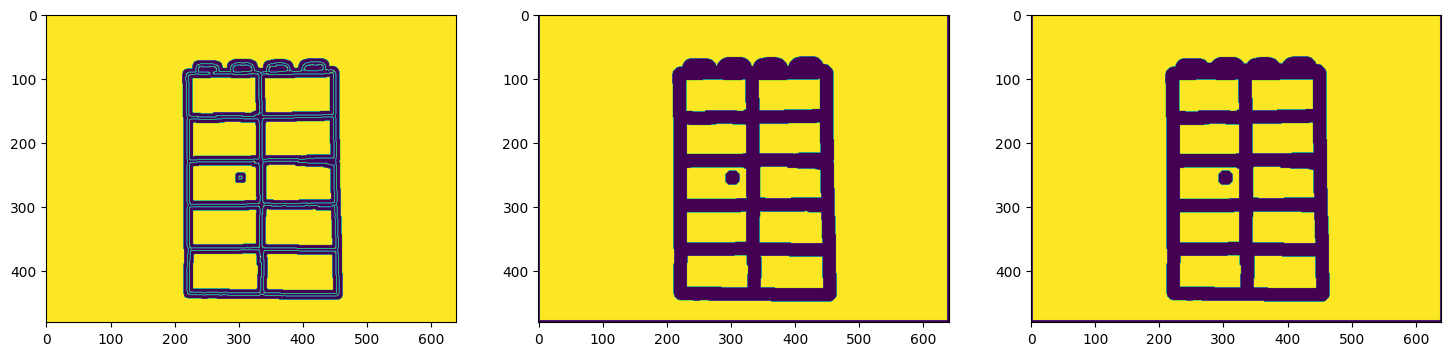

In [29]:
thresh = cv2.adaptiveThreshold(edges_r, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 3)
plt.figure(figsize=(18, 6)) 
plt.subplot(1, 3, 1)
plt.imshow(thresh)
thresh_cpy = thresh.copy()
cnts = cv2.findContours(thresh_cpy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh_cpy, [c], -1, (0,0,0), 4)
plt.subplot(1, 3, 2)
plt.imshow(thresh_cpy)
# Morph open
thresh_cpy_2 = thresh_cpy.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
opening = cv2.morphologyEx(thresh_cpy_2, cv2.MORPH_OPEN, kernel, iterations=1)
plt.subplot(1, 3, 3)
plt.imshow(opening)

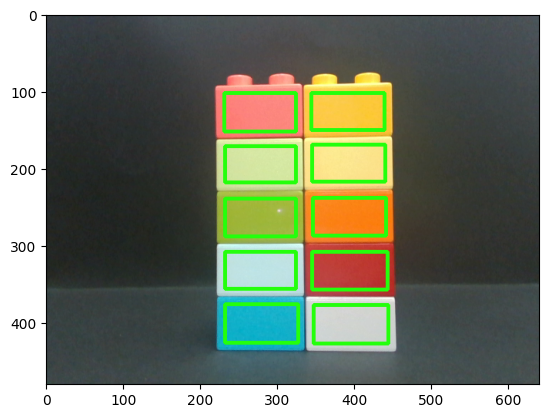

In [30]:
# Draw rectangles, the 'area_treshold' value was determined empirically
opening_cpy = opening.copy()
image_cpy = img.copy()
cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
area_treshold = 40000
area_min = 1000
legos = []
for c in cnts:
    area = cv2.contourArea(c)
    if area > area_min and area < area_treshold :
      x,y,w,h = cv2.boundingRect(c)
      legos.append([x, y, w, h])
      cv2.rectangle(image_cpy, (x, y), (x + w, y + h), (36,255,12), 3)

plt.imshow(image_cpy)
plt.show()

In [31]:
# Primero arreglamos las x's
xlegos = legos.copy()
xlegos.sort(key=lambda x: x[0])
legos_x = [] # here we will save a list of lists. Each list will consist of similar x position.

while (len(xlegos)>0):
    compare_x = []
    lego = xlegos.pop(0)
    compare_x.append(lego)
    x_ref, _, _, _ = lego
    # print(lego)
    # print(compare_x)
    # print(x_ref)
    # print(10*"-")
    ilego = []
    for i in range(len(xlegos)):
        x, _, _, _ = xlegos[i]
        # print(x)
        if (abs(x - x_ref) <= 6):
            ilego.append(i)
            # print(ilego)
    # print(10*"-")
    for i in ilego:      
        lego = xlegos[i]
        compare_x.append(lego)
    legos_x.append(compare_x)
    xlegos = [xlegos[i] for i in range(len(xlegos)) if i not in ilego]
    # print(compare_x)
    # print(60*"-")

In [32]:
# legos_x

In [33]:
for i in range(len(legos_x)):
    sum = []
    for j in range(len(legos_x[i])):
        x, _, _, _ = legos_x[i][j]
        sum.append(x)
    the_mean = np.mean(sum)
    for j in range(len(legos_x[i])):
        legos_x[i][j][0] = round(the_mean)
# print(legos_x)
lego_columns = len(legos_x)

In [34]:
# legos_x

In [35]:
xlegos = []
for i in range(len(legos_x)):
    for j in range(len(legos_x[i])):
        legos_x[i][j].append([i+1])
        xlegos.append(legos_x[i][j]) 

In [36]:
xlegos

[[232, 102, 93, 50, [1]],
 [232, 376, 95, 50, [1]],
 [232, 308, 92, 48, [1]],
 [232, 239, 92, 49, [1]],
 [232, 171, 92, 47, [1]],
 [345, 102, 95, 48, [2]],
 [345, 308, 98, 49, [2]],
 [345, 169, 95, 48, [2]],
 [345, 238, 95, 49, [2]],
 [345, 377, 97, 50, [2]]]

In [37]:
ylegos = xlegos.copy()
ylegos.sort(key=lambda x: x[1])
legos_y = []

while (len(ylegos)>0):
    compare_y = []
    lego = ylegos.pop(0)
    compare_y.append(lego)
    _, y_ref, _, _, _ = lego
    # print(lego)
    # print(compare_y)
    # print(y_ref)
    # print(10*"-")
    ilego = []
    for i in range(len(ylegos)):
        _, y, _, _, _ = ylegos[i]
        # print(y)
        if (abs(y - y_ref) <= 6):
            ilego.append(i)
            # print(ilego)
    # print(10*"-")
    for i in ilego:      
        lego = ylegos[i]
        compare_y.append(lego)
    legos_y.append(compare_y)
    ylegos = [ylegos[i] for i in range(len(ylegos)) if i not in ilego]
    # print(compare_y)
    # print(legos_y)
    # print(60*"-")

In [38]:
for i in range(len(legos_y)):
    sum = []
    for j in range(len(legos_y[i])):
        _, y, _, _, _ = legos_y[i][j]
        sum.append(y)
    the_mean = np.mean(sum)
    for j in range(len(legos_y[i])):
        legos_y[i][j][1] = round(the_mean)
lego_rows = len(legos_y)

In [39]:
legos_y

[[[232, 102, 93, 50, [1]], [345, 102, 95, 48, [2]]],
 [[345, 170, 95, 48, [2]], [232, 170, 92, 47, [1]]],
 [[345, 238, 95, 49, [2]], [232, 238, 92, 49, [1]]],
 [[232, 308, 92, 48, [1]], [345, 308, 98, 49, [2]]],
 [[232, 376, 95, 50, [1]], [345, 376, 97, 50, [2]]]]

In [40]:
legos = []
for i in range(len(legos_y)):
    for j in range(len(legos_y[i])):
        legos_y[i][j][4].append(len(legos_y)-i)
        legos.append(legos_y[i][j]) 


In [41]:
legos

[[232, 102, 93, 50, [1, 5]],
 [345, 102, 95, 48, [2, 5]],
 [345, 170, 95, 48, [2, 4]],
 [232, 170, 92, 47, [1, 4]],
 [345, 238, 95, 49, [2, 3]],
 [232, 238, 92, 49, [1, 3]],
 [232, 308, 92, 48, [1, 2]],
 [345, 308, 98, 49, [2, 2]],
 [232, 376, 95, 50, [1, 1]],
 [345, 376, 97, 50, [2, 1]]]

In [42]:
colors = {
    'blue': {
        'rgb': [13, 177, 200], 
        'hsv': [94, 238, 200]},
    'light_blue': {
        'rgb': [191, 228, 231], 
        'hsv': [92, 44, 231]},
    'white': {
        'rgb': [206, 209, 208], 
        'hsv': [80, 4, 209]},
    'red': {
        'rgb': [191, 62, 59], 
        'hsv': [1, 176, 191]},
    'light_red': {
        'rgb': [253, 132, 126], 
        'hsv': [1, 128, 253]},
    'orange': {
        'rgb': [252, 129, 21], 
        'hsv': [14, 234, 252]},
    'green': {
        'rgb': [158, 181, 57], 
        'hsv': [36, 175, 181]},
    'light_green': {
        'rgb': [213, 232, 163], 
        'hsv': [38, 76, 232]},
    'light_yellow': {
        'rgb': [251, 230, 143], 
        'hsv': [24, 110, 251]},
    'yellow': {
        'rgb': [251, 202, 73], 
        'hsv': [22, 181, 251]}
}

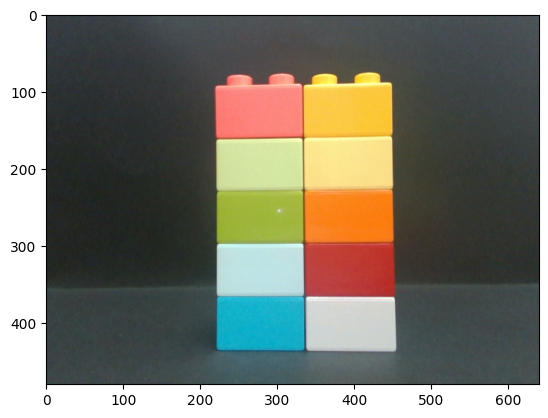

In [43]:
plt.imshow(img)

In [44]:
img_copy = img.copy()
for i in range(len((legos))):
    print(i)
    x, y, w, h, _ = legos[i]
    roi = img_copy[y:y+h, x:x+w]
    r = roi[:,:,0]
    g = roi[:,:,1]
    b = roi[:,:,2]
    r = round(np.mean(r))
    g = round(np.mean(g))
    b = round(np.mean(b))
    print("new color!", r,g,b)
    for key, value in colors.items():
        for space, value in value.items():
            if space == 'hsv':
                continue
            add = 10
            plus = [x + add for x in value]
            minus = [x - add for x in value]
            if ( (r <= plus[0] and r >= minus[0]) and (g <= plus[1] and g >= minus[1]) and (b <= plus[2] and b >= minus[2]) ):
                print((r, g, b), minus, plus, value)
                legos[i].append(value)
                legos[i].append(key)

0
new color! 253 133 125
(253, 133, 125) [243, 122, 116] [263, 142, 136] [253, 132, 126]
1
new color! 253 202 65
(253, 202, 65) [241, 192, 63] [261, 212, 83] [251, 202, 73]
2
new color! 252 229 141
(252, 229, 141) [241, 220, 133] [261, 240, 153] [251, 230, 143]
3
new color! 213 231 163
(213, 231, 163) [203, 222, 153] [223, 242, 173] [213, 232, 163]
4
new color! 252 130 24
(252, 130, 24) [242, 119, 11] [262, 139, 31] [252, 129, 21]
5
new color! 161 183 61
(161, 183, 61) [148, 171, 47] [168, 191, 67] [158, 181, 57]
6
new color! 191 227 227
(191, 227, 227) [181, 218, 221] [201, 238, 241] [191, 228, 231]
7
new color! 189 60 55
(189, 60, 55) [181, 52, 49] [201, 72, 69] [191, 62, 59]
8
new color! 18 177 202
(18, 177, 202) [3, 167, 190] [23, 187, 210] [13, 177, 200]
9
new color! 209 212 209
(209, 212, 209) [196, 199, 198] [216, 219, 218] [206, 209, 208]


In [45]:
# # Define the number of rows and columns for the grid
# num_rows = 5  # Example number of rows
# num_cols = 2  # Example number of columns

# # Create a figure and axis objects for the grid
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# # Loop through each ROI and plot it in the grid
# for i in range(len(legos)):
#     # Calculate the position in the grid
#     row = i // num_cols
#     col = i % num_cols
    
#     # Extract the ROI
#     rgb = legos[i][5]
    
#     # Plot the ROI in the corresponding subplot
#     axs[row, col].imshow([[rgb]])
#     axs[row, col].set_title(f'ROI {i+1}')  # Set a title for each subplot

# # Adjust layout
# plt.tight_layout()


In [46]:
legos

[[232, 102, 93, 50, [1, 5], [253, 132, 126], 'light_red'],
 [345, 102, 95, 48, [2, 5], [251, 202, 73], 'yellow'],
 [345, 170, 95, 48, [2, 4], [251, 230, 143], 'light_yellow'],
 [232, 170, 92, 47, [1, 4], [213, 232, 163], 'light_green'],
 [345, 238, 95, 49, [2, 3], [252, 129, 21], 'orange'],
 [232, 238, 92, 49, [1, 3], [158, 181, 57], 'green'],
 [232, 308, 92, 48, [1, 2], [191, 228, 231], 'light_blue'],
 [345, 308, 98, 49, [2, 2], [191, 62, 59], 'red'],
 [232, 376, 95, 50, [1, 1], [13, 177, 200], 'blue'],
 [345, 376, 97, 50, [2, 1], [206, 209, 208], 'white']]

In [47]:
# Lets build!!!
my_legos = legos.copy()

for j in range(1,lego_rows+1):
    for i in range(1,lego_columns+1):
        # print(i,j)
        for my_lego in my_legos:
            if ( (my_lego[4][0] == i) and (my_lego[4][1] == j)):
                print(my_lego)

[232, 376, 95, 50, [1, 1], [13, 177, 200], 'blue']
[345, 376, 97, 50, [2, 1], [206, 209, 208], 'white']
[232, 308, 92, 48, [1, 2], [191, 228, 231], 'light_blue']
[345, 308, 98, 49, [2, 2], [191, 62, 59], 'red']
[232, 238, 92, 49, [1, 3], [158, 181, 57], 'green']
[345, 238, 95, 49, [2, 3], [252, 129, 21], 'orange']
[232, 170, 92, 47, [1, 4], [213, 232, 163], 'light_green']
[345, 170, 95, 48, [2, 4], [251, 230, 143], 'light_yellow']
[232, 102, 93, 50, [1, 5], [253, 132, 126], 'light_red']
[345, 102, 95, 48, [2, 5], [251, 202, 73], 'yellow']


# Code Bin

## Color segmentation

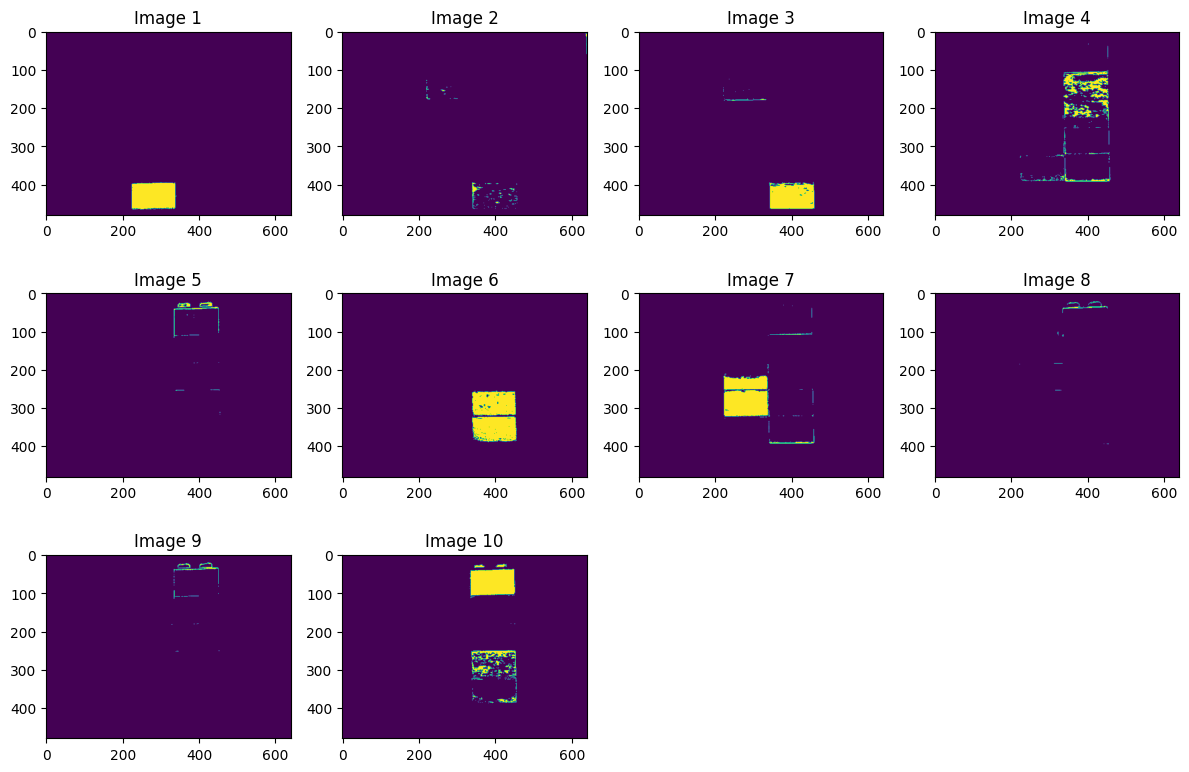

In [258]:
## Convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
images_masked = []
for key, value in colors.items():
    for space, value in value.items():
        if space == 'rgb':
            continue
        add = 30
        value_plus = tuple([x + add for x in value])
        value_minus = tuple([x - add for x in value])
        images_masked.append(cv2.inRange(hsv, value_minus, value_plus))

num_images = len(images_masked)
num_cols = 4  # Number of columns in the grid
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows based on the number of images

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Adjust the figsize as needed

# Iterate through the images and plot them in the subplots
for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(images_masked[i])
    axs[row, col].set_title(f'Image {i+1}')  # Set title for each subplot

# Hide empty subplots
for i in range(num_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## One option

In [20]:
filepath = r'../test_images/1.jpg'
img = cv2.imread(filepath) # we use skimage because it load the .jpg wiht RGB colors
img.shape
plt.imshow(img)
imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_,imgThreshold = cv2.threshold(img,120,255,cv2.THRESH_BINARY_INV)

plt.figure()
plt.subplot(231)
plt.imshow(img)
plt.subplot(232)
plt.imshow(imgThreshold,cmap='gray')
kernel = np.ones((3,3),np.uint8)
imgDilate = cv2.morphologyEx(imgThreshold,cv2.MORPH_DILATE,kernel)
plt.subplot(233)
plt.imshow(imgDilate)
# computes distance from current pixel to nearest 0 pixel
distTrans = cv2.distanceTransform(imgDilate,cv2.DIST_L2,5)
plt.subplot(234)
plt.imshow(distTrans)
_,distThresh = cv2.threshold(distTrans,15,255,cv2.THRESH_BINARY)
plt.subplot(235)
plt.imshow(distThresh)
distThresh = np.uint8(distThresh)
_,labels = cv2.connectedComponents(distThresh)
plt.subplot(236)
plt.imshow(labels)
plt.figure() 
plt.subplot(121)
labels = np.int32(labels)
labels = cv2.watershed(imgRGB,labels)
plt.imshow(labels)
plt.subplot(122)
imgRGB[labels==-1] = [255,0,0]
plt.imshow(imgRGB)
plt.show()  

[ WARN:0@1135.692] global loadsave.cpp:248 findDecoder imread_('../test_images/1.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

## Superpixel

Felzenszwalb number of segments: 194
SLIC number of segments: 196
Quickshift number of segments: 695
Watershed number of segments: 256


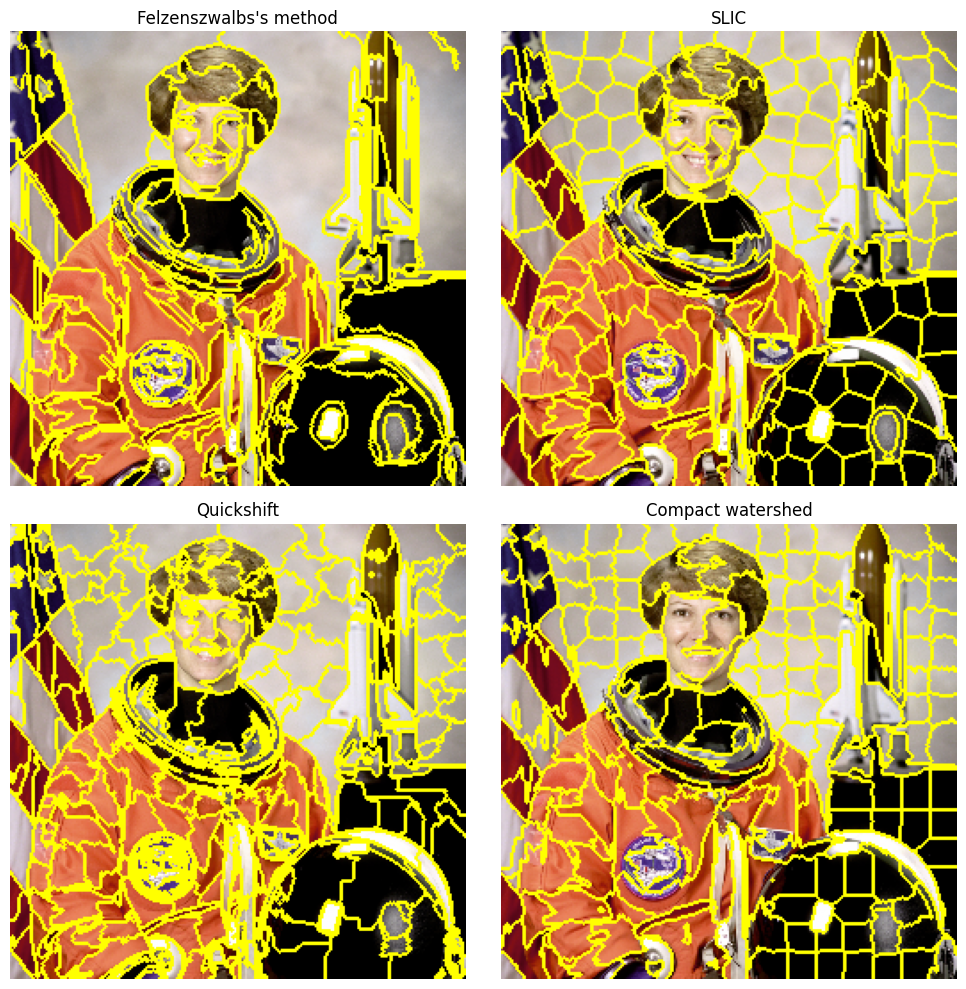

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(astronaut()[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1, start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()